In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import numpy as np
import random
from sklearn import preprocessing
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.regularizers import l2
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

# Settings the warnings to be ignored
import warnings  
warnings.filterwarnings('ignore') 


In [2]:
train_dir = '../data/training'
testing_dir = '../data/testing'

In [3]:
glob.glob(os.path.join(train_dir,'*'))

['../data/training/02-moderate',
 '../data/training/01-minor',
 '../data/training/03-severe']

In [4]:
image_paths = glob.glob(os.path.join(train_dir,'01-minor','*'))
image_paths += glob.glob(os.path.join(train_dir,'02-moderate','*'))
image_paths += glob.glob(os.path.join(train_dir,'03-severe','*'))
image_paths += glob.glob(os.path.join(testing_dir,'01-minor','*'))
image_paths += glob.glob(os.path.join(testing_dir,'02-moderate','*'))
image_paths += glob.glob(os.path.join(testing_dir,'03-severe','*'))

In [5]:
len(image_paths)

1600

In [7]:
# Set up paths and labels
severity_levels = ['01-minor', '02-moderate', '03-severe']  # Labels by order

# Initialize lists for images and labels
images = []
labels = []
labels_values = []

# Load images and labels in a single loop
for values, level in enumerate(severity_levels):
    for image_path in glob.glob(os.path.join(train_dir, level, '*')):
        img = cv2.imread(image_path)  # Read image
        img_resized = cv2.resize(img, (255, 255))  # Resize image
        images.append(img_resized)  # Append resized image
        labels.append(level)
        labels_values.append(values)
    for image_path in glob.glob(os.path.join(testing_dir, level, '*')):
        img = cv2.imread(image_path)  # Read image
        img_resized = cv2.resize(img, (255, 255))  # Resize image
        images.append(img_resized)  # Append resized image
        labels.append(level)
        labels_values.append(values)

Severity Level:  03-severe
Severity Level Value:  2


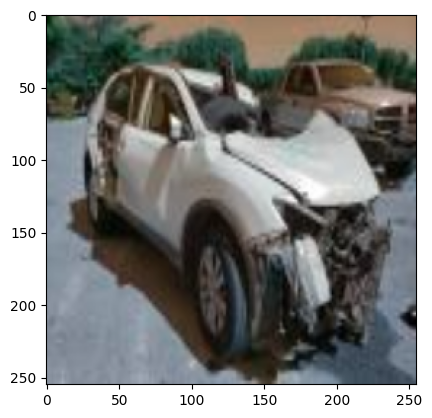

In [8]:
sample_number = 1598
plt.imshow(images[sample_number])
print(f'Severity Level: ',labels[sample_number])
print(f'Severity Level Value: ',labels_values[sample_number])

In [9]:
# Convert lists to numpy arrays
images = np.asarray(images, dtype='float32')
labels = np.array(labels)
labels_values = np.asarray(labels_values, dtype='int32')

In [10]:
augmentor = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1
)

In [11]:
augmented_images = augmentor.flow(images,
                                  labels_values, 
                                  seed=42,
                                  shuffle=False)

In [12]:
for i in range(0,50):
    imgs, labels = next(augmented_images)
    images = np.concatenate((images, imgs), axis=0)
    labels_values= np.concatenate((labels_values, labels), axis=0)

In [13]:
print(images.shape)
print(labels_values.shape)

(3200, 255, 255, 3)
(3200,)


In [14]:
data = images.flatten().reshape(images.shape[0],195075)

In [15]:
# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
s_data = scaler.fit_transform(data)

# print(scaler.mean_)
# print(scaler.scale_)
s_data.shape
#s_train_data.shape.mean(axis=0)
#s_train_data.shape.std(axis=0)

(3200, 195075)

In [16]:
labels_one_hot = to_categorical(labels_values, num_classes=3)

In [17]:
labels_one_hot.shape

(3200, 3)

In [18]:
# Using sklearn's train_test_split to split data
X_train, X_test, y_train, y_test = train_test_split(s_data, labels_one_hot , random_state=42, test_size=0.20)

In [19]:
input_dim = s_data.shape[1]
hidden_dim = 100
output_dim = labels_one_hot.shape[1]

model = Sequential()
model.add(Dense(hidden_dim, input_dim=input_dim, activation="tanh", kernel_regularizer=l2(0.001)))
model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))  # 50% dropout rate
model.add(Dense(output_dim, activation="softmax", kernel_regularizer=l2(0.001)))
model.compile(optimizer=optimizers.SGD(nesterov=True, learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=25, batch_size=32)

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3418 - loss: 2.4506 - val_accuracy: 0.4141 - val_loss: 1.9884
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4280 - loss: 2.1223 - val_accuracy: 0.4453 - val_loss: 1.9217
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4840 - loss: 1.9575 - val_accuracy: 0.4844 - val_loss: 1.9173
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4928 - loss: 1.9142 - val_accuracy: 0.4336 - val_loss: 1.9594
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5215 - loss: 1.8493 - val_accuracy: 0.4844 - val_loss: 1.9103
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.5791 - loss: 1.7776 - val_accuracy: 0.4102 - val_loss: 1.9516
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5794 - loss: 1.7612 - val_accuracy: 0.4336 - val_loss: 1.9228
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5963 - loss: 1.7021 - val_accuracy: 0.4297 - v

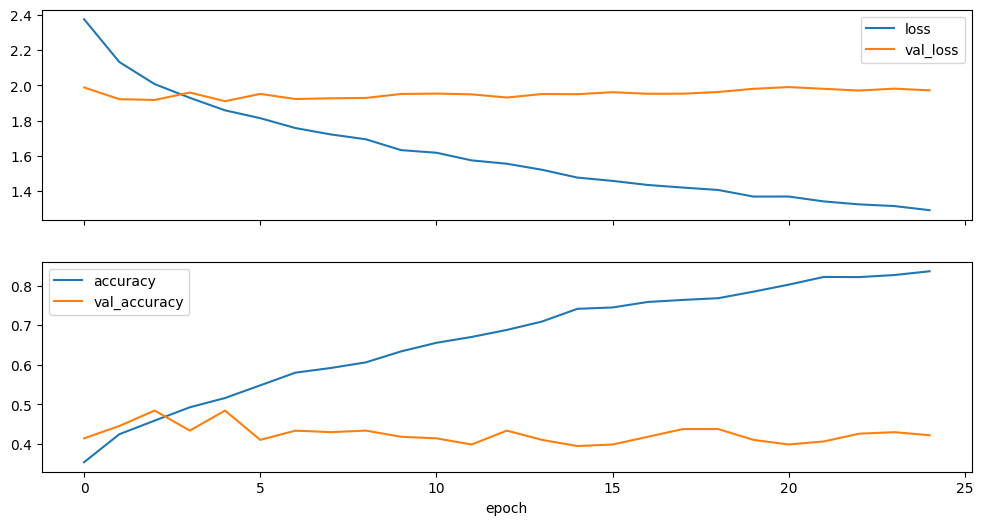

In [20]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [21]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [22]:
y_train_labels = np.argmax(y_train, axis=1)

Training Confusion Matrix:


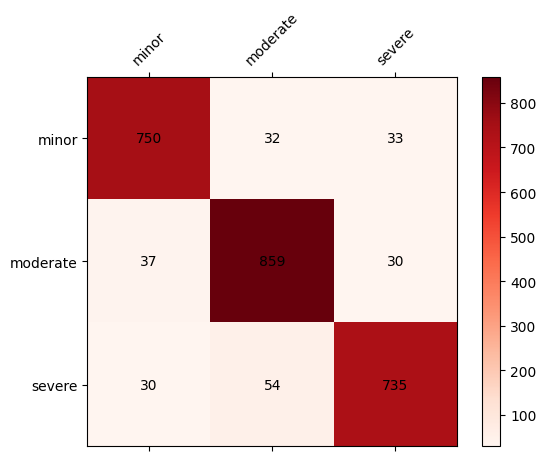

In [23]:
conf_matrix = confusion_matrix(y_train_labels, y_train_pred)
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')
print('Training Confusion Matrix:')

plt.show()

In [24]:
# Print classification report
print(classification_report(y_train_labels, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       815
           1       0.91      0.93      0.92       926
           2       0.92      0.90      0.91       819

    accuracy                           0.92      2560
   macro avg       0.92      0.92      0.92      2560
weighted avg       0.92      0.92      0.92      2560



In [25]:
y_pred = np.argmax(model.predict(X_test), axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
y_test_labels = np.argmax(y_test, axis=1)

In [27]:
# Print classification report
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.46      0.48       243
           1       0.36      0.40      0.38       204
           2       0.40      0.40      0.40       193

    accuracy                           0.42       640
   macro avg       0.42      0.42      0.42       640
weighted avg       0.43      0.42      0.43       640



Testing Confusion Matrix:


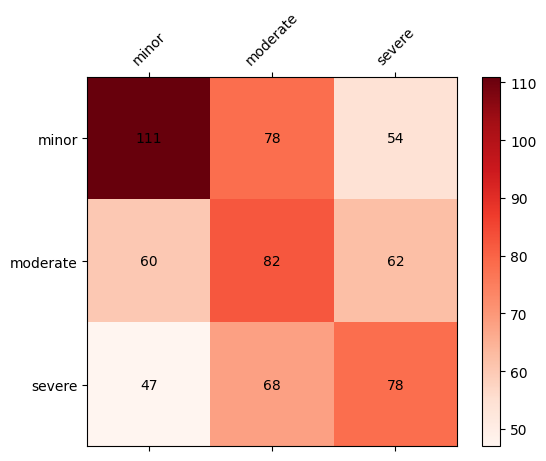

In [28]:
conf_matrix = confusion_matrix(y_test_labels, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Reds')

cbar = fig.colorbar(cax)

ax.set_xticklabels([''] + ['minor', 'moderate', 'severe'], rotation=45)
ax.set_yticklabels([''] + ['minor', 'moderate', 'severe'])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')
print('Testing Confusion Matrix:')

plt.show()